In [56]:
#import libraries
import torch
import torch.nn as nn
import shutil
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset,DataLoader,random_split
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from PIL import Image,ImageFile
import torch.optim as optim
import pandas as pd
import copy
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
import cv2
from torchvision import transforms
import albumentations as augment
from albumentations.pytorch import ToTensorV2
import numpy as np
import timm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [57]:
seed_val = 420
torch.manual_seed(seed_val)

In [58]:
inference_data_path = '../data/deepfakeart/original_all'

LOAD PRETRAINED MODEL

In [59]:
model = timm.create_model('convnext_base', pretrained=False, num_classes=2)  
model_path = 'saved_models/convnext_model/RealArt_vs_FakeArt_convnext_base_plain.pt'
# model.load_state_dict(torch.load(model_path, map_location=device))
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()
print(model)

/tmp/ipykernel_95606/2809157573.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

LOADING TEST DATA

In [60]:
test_data_transforms = transforms.Compose([
    transforms.Lambda(lambda img: transforms.functional.pad(
        img, 
        (
            (max(img.size) - img.size[0]) // 2,  # Padding on the left
            (max(img.size) - img.size[1]) // 2,  # Padding on the top
            (max(img.size) - img.size[0] + 1) // 2,  # Padding on the right
            (max(img.size) - img.size[1] + 1) // 2   # Padding on the bottom
        ), 
            fill=0)),  # Pad image to square (by adding black padding)
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


test_dataset = datasets.ImageFolder(inference_data_path, transform=test_data_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers = 4)

for images, labels in test_loader:
    print(images.shape)  # Should be (batch_size, 3, 224, 224)
    break

torch.Size([32, 3, 224, 224])


In [61]:
print(f"Total number of samples in the test dataset: {len(test_dataset)}")

Total number of samples in the test dataset: 11047


In [62]:
for images, labels in test_loader:
    print(images.shape)  # Should be (batch_size, 3, 224, 224)
    break

torch.Size([32, 3, 224, 224])


torch.Size([32, 3, 224, 224])


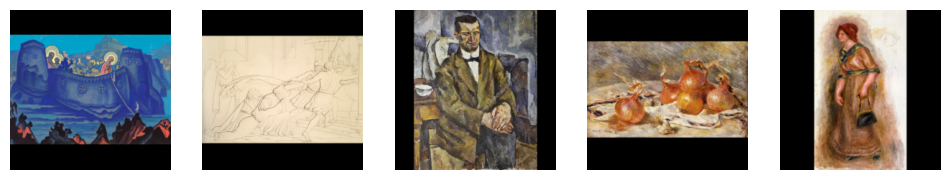

In [63]:
# Denormalize function (to reverse the normalization applied in the transform)
def denormalize_image(tensor, mean, std):
    tensor = tensor.clone().detach()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Revert normalization
    return tensor

# Function to display the images
def display_image(tensor, mean, std):
    # Denormalize the image tensor
    tensor = denormalize_image(tensor, mean, std)
    tensor = tensor.permute(1, 2, 0).numpy()  # Convert (C, H, W) -> (H, W, C)
    tensor = np.clip(tensor, 0, 1)  # Ensure values are in [0, 1]
    
    plt.imshow(tensor)
    plt.axis('off')  # Turn off axis

# Load a few images from the test_loader
plt.figure(figsize=(12, 3))  # Adjust the figure size to make it smaller and in one line

for images, labels in test_loader:
    print(images.shape)  # Should be (batch_size, 3, 224, 224)
    
    # Display the first 4 images from the batch
    for i in range(min(5, images.size(0))):  # Display up to 4 images
        plt.subplot(1, 5, i + 1)  # Create a subplot with 1 row and 4 columns
        display_image(images[i], mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    
    plt.show()  # Show all images in one line
    break  # Exit after the first batch

TESTING

In [64]:
writer = SummaryWriter("runs/deepfakeart/original")

In [65]:
# functions for logging the misclassified images in tensorboard
def denormalize_image(tensor, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """Denormalizes a tensor image by applying the inverse of the normalization transform."""
    # Reshape mean and std to match the (C, H, W) shape of the tensor
    mean = torch.tensor(mean).view(3, 1, 1).to(tensor.device)  # Match device as well
    std = torch.tensor(std).view(3, 1, 1).to(tensor.device)
    denormalized = tensor * std + mean
    return denormalized.clamp(0, 1)

def add_labels_to_image(image, true_label, pred_label):
    """Add true and predicted labels to the image."""
    # Convert the image to uint8 if it's in float format
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Convert from RGB to BGR for OpenCV
    bgr_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Prepare text without brackets
    text = f'True: {int(true_label)}, Pred: {int(pred_label)}'
    cv2.putText(bgr_image, text, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

    # Convert back to RGB before returning
    return cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

def log_misclassified_images(misclassified_images, misclassified_preds, misclassified_true, writer):
    print("Logging misclassified images...")
    print(len(misclassified_images))
    labeled_images = []

    for i, img in enumerate(misclassified_images):
        img = denormalize_image(img)  # Denormalize the image
        img_np = img.permute(1, 2, 0).numpy()  # Convert (C, H, W) -> (H, W, C)
      

        # Ensure the image is in the right format for TensorBoard
        if img_np.shape[-1] == 1:  # Check if the image is grayscale
            img_np = img_np.squeeze(axis=2)  # Remove the channel dimension if it is 1
        elif img_np.shape[0] == 1:  # If the shape is (1, H, W)
            img_np = img_np.squeeze(axis=0)  # Remove the batch dimension
        img_np = np.clip(img_np, 0, 1)  # Ensure the values are between 0 and 1
        img_np = (img_np * 255).astype(np.uint8)     # Scale to 0-255

        true_label = misclassified_true[i]
        pred_label = misclassified_preds[i]

        labeled_image = add_labels_to_image(img_np, true_label, pred_label)
        # labeled_image = labeled_image.transpose(2, 0, 1)
        labeled_images.append(labeled_image)

    # Log image to TensorBoard
    writer.add_images(
        f'Misclassified',
        np.array(labeled_images),
        dataformats='NHWC'
    )

In [66]:
def test_model(model, test_loader, true_label):
    model.eval() 
    test_loss = 0
    correct = 0
    
    pred_list = []
    true_list = []
    misclassified_images = []
    misclassified_preds = []
    misclassified_true = []

    pbar = tqdm(total=len(test_loader))
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() 
            
            # get the predicted class
            pred = output.argmax(dim=1, keepdim=True)
            pred_list.extend(pred.cpu().numpy())
            # true_list.extend(target.cpu().numpy()) 

            # True label is always 1 for originals
            true_labels = torch.tensor([true_label] * len(target), device=device)
            true_list.extend(true_labels.cpu().numpy())

            
            correct += pred.eq(true_labels.view_as(pred)).sum().item()  # Update the correct count
            misclassified = ~pred.eq(true_labels.view_as(pred)).squeeze()  
            
            if misclassified.any():
                misclassified_images.extend(data[misclassified].cpu())  # This correctly indexes along the batch dimension
                misclassified_preds.extend(pred[misclassified].cpu().numpy())
                misclassified_true.extend(true_labels[misclassified].cpu().numpy())


            # update progress bar
            pbar.update(1)
            
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    recall = recall_score(true_list, pred_list, average='macro') # calcolo la recall
    precision = precision_score(true_list, pred_list, average='macro') # calcolo la precision
    f1 = f1_score(true_list, pred_list, average='macro') # calcolo la F1 score
    # auc = roc_auc_score(true_list, pred_list) # calcolo l'AUC
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%), Recall: {:.2f}%, Precision: {:.2f}%, F1: {:.2f}%'.format(
        test_loss, correct, len(test_loader.dataset), accuracy, recall*100, precision*100, f1*100))
    
    log_misclassified_images(misclassified_images, misclassified_preds, misclassified_true, writer)
    writer.flush()
    return accuracy, recall, precision, f1

use this for logs:
tensorboard --logdir=./runs

In [67]:
true_label = 1
accuracy,recall,precision,f1= test_model(model,test_loader, true_label)
writer.close()

  0%|          | 0/346 [00:00<?, ?it/s]

100%|█████████▉| 345/346 [01:16<00:00,  1.54it/s]/home/oem/miniconda3/envs/python3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_95606/974132181.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  text = f'True: {int(true_label)}, Pred: {int(pred_label)}'



Test set: Average loss: 14.2938, Accuracy: 10178/11047 (92.13%), Recall: 46.07%, Precision: 50.00%, F1: 47.95%
Logging misclassified images...
869


100%|██████████| 346/346 [01:27<00:00,  3.97it/s]
